<a href="https://colab.research.google.com/github/JohnnyWalker010/fraud_transaction_detection/blob/main/fraud_transactions_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [385]:
import time
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

# Load dataset
file_path = r"/Users/yevhen_omelianenko/fraud_transaction_detection/dataset.csv"
df = pd.read_csv(file_path)

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

Dataset loaded successfully!
Shape: (31498, 688)

First 5 rows:
         id target sample_type  continuous_0  categorical_0  categorical_1  \
0  14537510   good         dev           1.0            0.0            0.0   
1  12527950   good         dev           1.0            1.0            1.0   
2  12277478   good         dev           1.0            1.0            1.0   
3  13362203   good         dev           1.0            1.0            2.0   
4  14036057    bad         dev           1.0            1.0            1.0   

   categorical_2  categorical_3  categorical_4  categorical_5  ...  \
0            0.0            0.0            0.0            0.0  ...   
1            1.0            1.0            1.0            0.0  ...   
2            1.0            1.0            2.0            0.0  ...   
3            2.0            2.0            3.0            0.0  ...   
4            1.0            1.0            1.0            0.0  ...   

   continuous_660  continuous_661  continuous_

In [386]:
# General preliminary view of the dataset
print("Dataset statistics:")
print(df.describe())

# Identify categorical and continuous columns
categorical_cols = [col for col in df.columns if "categorical" in col.lower()]
continuous_cols = [col for col in df.columns if "continuous" in col.lower()]
total_cols_count = len(df.columns)

print(
    f"There are {len(categorical_cols)} categorical columns and {len(continuous_cols)} continuous columns among {total_cols_count} columns"
)

# Split the dataset based on 'sample_type' column
df_dev = df[df["sample_type"] == "dev"].copy()
df_test = df[df["sample_type"] == "test"].copy()
df_valid = df[df["sample_type"] == "valid"].copy()

print(
    f"\nDataset split sizes: Dev={len(df_dev)}, Test={len(df_test)}, Valid={len(df_valid)}"
)

Dataset statistics:
                 id  continuous_0  categorical_0  categorical_1  \
count  3.149800e+04  31498.000000   31498.000000   31498.000000   
mean   1.254142e+07      0.983777       1.352022       8.705188   
std    2.301706e+06      0.126335       1.002153       6.513199   
min    9.004705e+06      0.000000       0.000000       0.000000   
25%    1.035565e+07      1.000000       1.000000       3.000000   
50%    1.230090e+07      1.000000       1.000000       8.000000   
75%    1.447697e+07      1.000000       1.000000      13.000000   
max    1.712175e+07      1.000000       7.000000      26.000000   

       categorical_2  categorical_3  categorical_4  categorical_5  \
count   31498.000000   31498.000000   31498.000000   31498.000000   
mean        8.717823       8.729126       8.936980       0.512890   
std         6.527480       6.529695       6.759147       0.982387   
min         0.000000       0.000000       0.000000       0.000000   
25%         3.000000       3.00

Means there are 'id', 'target', and 'sample_type' columns (3), and all others contain whether 'categorical' (15) or 'continuous' (492) word in their names (3 + 15 + 492 = 510). The split is done before any preprocessing in order to avoid data leakage.

In [387]:
# Identify columns with more than 30% NaN values in dev set
nan_threshold_perc = 30
nan_percentages_dev = df_dev.isna().mean() * 100
high_nan_cols = nan_percentages_dev[nan_percentages_dev > nan_threshold_perc]

print(
    f"Number of columns with more than {nan_threshold_perc}% NaN in DEV set: {len(high_nan_cols)}"
)
if len(high_nan_cols) > 0:
    print(
        f"Columns to be dropped: {list(high_nan_cols.index[:10])}..."
        if len(high_nan_cols) > 10
        else f"Columns to be dropped: {list(high_nan_cols.index)}"
    )

# Drop high NaN columns from all splits
df_dev.drop(columns=high_nan_cols.index, inplace=True)
df_test.drop(columns=high_nan_cols.index, inplace=True)
df_valid.drop(columns=high_nan_cols.index, inplace=True)

print(f"\nAfter dropping high NaN columns:")
print(f"Dev shape: {df_dev.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Valid shape: {df_valid.shape}")

# Update column lists after dropping
categorical_cols = [col for col in df_dev.columns if "categorical" in col.lower()]
continuous_cols = [col for col in df_dev.columns if "continuous" in col.lower()]

print(
    f"Updated: {len(categorical_cols)} categorical columns and {len(continuous_cols)} continuous columns"
)

Number of columns with more than 30% NaN in DEV set: 178
Columns to be dropped: ['continuous_471', 'continuous_472', 'continuous_480', 'continuous_481', 'continuous_482', 'continuous_483', 'continuous_484', 'continuous_485', 'continuous_486', 'continuous_487']...

After dropping high NaN columns:
Dev shape: (19368, 510)
Test shape: (6130, 510)
Valid shape: (6000, 510)
Updated: 15 categorical columns and 492 continuous columns


The 178 columns with more than 30% of NaN values were deleted, which is a good practise of preprocessing. The assession was made based only on the dev set, so that now data leakage happens.

In [388]:
def impute_data(df_subset, categorical_cols, continuous_cols):
    """Function to perform imputation on a given dataframe"""
    dataset_name = df_subset["sample_type"].iloc[0]
    print(f"\nImputing {dataset_name} set...")

    # For categorical columns - use mode
    for col in categorical_cols:
        if not df_subset[col].isna().all():
            mode_value = df_subset[col].mode()
            if len(mode_value) > 0:
                df_subset[col] = df_subset[col].fillna(mode_value[0])

    # For continuous columns - use median
    imputer = SimpleImputer(strategy="median")
    df_subset[continuous_cols] = imputer.fit_transform(df_subset[continuous_cols])

    print(f"NaN count after imputation: {df_subset.isna().sum().sum()}")
    return df_subset


# Apply imputation to each split
df_dev = impute_data(df_dev, categorical_cols, continuous_cols)
df_test = impute_data(df_test, categorical_cols, continuous_cols)
df_valid = impute_data(df_valid, categorical_cols, continuous_cols)

print("\n=== Final Dataset Summary ===")
print(f"Dev: {df_dev.shape}, NaN count: {df_dev.isna().sum().sum()}")
print(f"Test: {df_test.shape}, NaN count: {df_test.isna().sum().sum()}")
print(f"Valid: {df_valid.shape}, NaN count: {df_valid.isna().sum().sum()}")


Imputing dev set...
NaN count after imputation: 0

Imputing test set...
NaN count after imputation: 0

Imputing valid set...
NaN count after imputation: 0

=== Final Dataset Summary ===
Dev: (19368, 510), NaN count: 0
Test: (6130, 510), NaN count: 0
Valid: (6000, 510), NaN count: 0


In [389]:
# Extract features and targets
feature_cols = [
    col for col in df_dev.columns if col not in ["sample_type", "target", "id"]
]
X_dev = df_dev[feature_cols]
y_dev = df_dev["target"]
X_test = df_test[feature_cols]
y_test = df_test["target"]
X_valid = df_valid[feature_cols]
y_valid = df_valid["target"]

# Encode target labels (manually map to ensure correct encoding)


def encode_target(target_series):
    return target_series.map({"good": 0, "bad": 1})


y_dev = encode_target(df_dev["target"])
y_test = encode_target(df_test["target"])
y_valid = encode_target(df_valid["target"])

# Create label encoder for class names (for reference)
label_encoder = LabelEncoder()
label_encoder.fit(["good", "bad"])

print("Feature and target shapes:")
print(f"Development set: X_dev={X_dev.shape}, y_dev={y_dev.shape}")
print(f"Test set: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"Validation set: X_valid={X_valid.shape}, y_valid={y_valid.shape}")

# Analyze class imbalance
print("\n=== CLASS IMBALANCE ANALYSIS ===")
dev_class_counts = pd.Series(y_dev).value_counts().sort_index()
class_names = label_encoder.classes_

for i, count in enumerate(dev_class_counts):
    percentage = (count / len(y_dev)) * 100
    print(f"{class_names[i]}: {count:,} ({percentage:.2f}%)")

# Calculate scale_pos_weight for XGBoost
scale_pos_weight = len(y_dev[y_dev == 0]) / len(y_dev[y_dev == 1])
print(f"Scale pos weight (for XGBoost): {scale_pos_weight:.2f}")

Feature and target shapes:
Development set: X_dev=(19368, 507), y_dev=(19368,)
Test set: X_test=(6130, 507), y_test=(6130,)
Validation set: X_valid=(6000, 507), y_valid=(6000,)

=== CLASS IMBALANCE ANALYSIS ===
bad: 17,840 (92.11%)
good: 1,528 (7.89%)
Scale pos weight (for XGBoost): 11.68


In [390]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data only
smote = SMOTE(sampling_strategy=0.3, random_state=42)  # Increase minority to 30%
X_dev_balanced, y_dev_balanced = smote.fit_resample(X_dev, y_dev)

print(f"Original distribution: {pd.Series(y_dev).value_counts()}")
print(f"After SMOTE: {pd.Series(y_dev_balanced).value_counts()}")

Original distribution: target
0    17840
1     1528
Name: count, dtype: int64
After SMOTE: target
0    17840
1     5352
Name: count, dtype: int64


In [391]:
# ⚠️ WARNING: This cell takes 20+ minutes to run!
# Only run this if you want to find new hyperparameters
# Otherwise, skip to the next cell which uses pre-found optimal parameters

PERFORM_HYPERPARAMETER_SEARCH = False

if PERFORM_HYPERPARAMETER_SEARCH:
    print("🔍 Starting hyperparameter search...")

    # Define parameter grid
    param_dist = {
        "n_estimators": [400, 500, 600],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.005, 0.01, 0.05],
        "subsample": [0.5, 0.6, 0.7],
        "colsample_bytree": [0.6, 0.7, 0.8],
        "gamma": [0, 0.1],
        "reg_alpha": [0, 0.01, 0.1],
        "reg_lambda": [0.1, 1],
        "scale_pos_weight": [scale_pos_weight],
    }

    # Initialize XGBoost and RandomizedSearchCV
    xgb = XGBClassifier(random_state=42, eval_metric="logloss", verbosity=0)
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=20,
        cv=stratified_cv,
        scoring="average_precision",
        n_jobs=-1,
        verbose=2,
        random_state=42,
    )

    # Perform search
    start_time = time.time()
    random_search.fit(X_dev_balanced, y_dev_balanced)
    end_time = time.time()

    print(f"Training completed in {(end_time - start_time) / 60:.2f} minutes")
    print("\nBest hyperparameters found:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV Average Precision: {random_search.best_score_:.4f}")

    # Store the best model with consistent variable name
    best_xgb = random_search.best_estimator_

else:
    print("⏭️ Skipping hyperparameter search - using pre-found optimal parameters")
    # 🚀 Use pre-found optimal hyperparameters
    # These were found through previous RandomizedSearchCV runs

    OPTIMAL_PARAMS = {
        "subsample": 0.6,
        "scale_pos_weight": scale_pos_weight,  # Use calculated value
        "reg_lambda": 0.1,
        "reg_alpha": 0,
        "n_estimators": 600,
        "max_depth": 7,
        "learning_rate": 0.05,
        "gamma": 0.1,
        "colsample_bytree": 0.6,
        "random_state": 42,
        "eval_metric": "logloss",
        "verbosity": 0,
    }
    print("🔧 Training XGBoost with optimal parameters...")
    print("Optimal parameters:")
    for param, value in OPTIMAL_PARAMS.items():
        if param != "scale_pos_weight":  # Don't print the long float
            print(f"  {param}: {value}")
    print(f"  scale_pos_weight: {OPTIMAL_PARAMS['scale_pos_weight']:.3f}")

    # Train the model with optimal parameters
    start_time = time.time()
    best_xgb = XGBClassifier(**OPTIMAL_PARAMS)
    best_xgb.fit(X_dev_balanced, y_dev_balanced)
    end_time = time.time()

    print(f"✅ Model trained in {(end_time - start_time):.2f} seconds")

⏭️ Skipping hyperparameter search - using pre-found optimal parameters
🔧 Training XGBoost with optimal parameters...
Optimal parameters:
  subsample: 0.6
  reg_lambda: 0.1
  reg_alpha: 0
  n_estimators: 600
  max_depth: 7
  learning_rate: 0.05
  gamma: 0.1
  colsample_bytree: 0.6
  random_state: 42
  eval_metric: logloss
  verbosity: 0
  scale_pos_weight: 11.675
✅ Model trained in 10.78 seconds


In [392]:
# Generate predictions
y_pred_dev = best_xgb.predict(X_dev)
y_pred_test = best_xgb.predict(X_test)
y_pred_valid = best_xgb.predict(X_valid)

# Get prediction probabilities (important for fraud detection)
y_prob_dev = best_xgb.predict_proba(X_dev)[:, 1]  # Probability of fraud (class 1)
y_prob_test = best_xgb.predict_proba(X_test)[:, 1]
y_prob_valid = best_xgb.predict_proba(X_valid)[:, 1]


def evaluate_basic_metrics(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n=== {dataset_name} SET METRICS ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(
        f"Precision: {precision:.4f}"
    )  # Of predicted frauds, how many were actually fraud?
    print(f"Recall:    {recall:.4f}")  # Of actual frauds, how many did we catch?
    print(f"F1-Score:  {f1:.4f}")  # Harmonic mean of precision and recall


# Evaluate both sets
evaluate_basic_metrics(y_dev, y_pred_dev, "DEVELOPMENT")
evaluate_basic_metrics(y_test, y_pred_test, "TEST")
evaluate_basic_metrics(y_valid, y_pred_valid, "VALIDATION")


=== DEVELOPMENT SET METRICS ===
Accuracy:  0.9773
Precision: 0.7764
Recall:    1.0000
F1-Score:  0.8741

=== TEST SET METRICS ===
Accuracy:  0.9184
Precision: 0.3717
Recall:    0.0892
F1-Score:  0.1438

=== VALIDATION SET METRICS ===
Accuracy:  0.8900
Precision: 0.2810
Recall:    0.2036
F1-Score:  0.2361


In [393]:
# Calculate overfitting ratio


def calculate_overfitting_metrics(y_dev, y_pred_dev, y_valid, y_pred_valid):
    """
    Calculate metrics to detect overfitting
    """
    from sklearn.metrics import f1_score

    train_f1 = f1_score(y_dev, y_pred_dev)
    valid_f1 = f1_score(y_valid, y_pred_valid)

    overfit_ratio = train_f1 / valid_f1 if valid_f1 > 0 else float("inf")

    print("=== OVERFITTING ANALYSIS ===")
    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Validation F1 Score: {valid_f1:.4f}")
    print(f"Overfitting Ratio: {overfit_ratio:.2f}")

    if overfit_ratio > 2:
        print("⚠️ WARNING: Severe overfitting detected!")
        print("The model performs much better on training data than validation.")
        print(
            "This indicates the model has memorized training patterns that don't generalize."
        )
    elif overfit_ratio > 1.5:
        print("⚠️ Moderate overfitting detected.")
    else:
        print("✅ Good generalization!")

    return overfit_ratio


overfit_ratio = calculate_overfitting_metrics(y_dev, y_pred_dev, y_valid, y_pred_valid)

=== OVERFITTING ANALYSIS ===
Training F1 Score: 0.8741
Validation F1 Score: 0.2361
Overfitting Ratio: 3.70
⚠️ WARNING: Severe overfitting detected!
The model performs much better on training data than validation.
This indicates the model has memorized training patterns that don't generalize.


In [394]:
## Data Quality Diagnostics

def diagnose_data_issues(X_dev, y_dev, X_valid, y_valid, X_test, y_test):
    """
    Comprehensive data diagnostic to identify issues
    """

    print("=" * 60)
    print("DATA DIAGNOSTIC ANALYSIS")
    print("=" * 60)

    # 1. Class distribution
    print("\n1. CLASS DISTRIBUTION:")
    dev_ratio = y_dev.mean()
    valid_ratio = y_valid.mean()
    test_ratio = y_test.mean()

    print(f"Fraud ratio - Dev: {dev_ratio:.3%}")
    print(f"Fraud ratio - Valid: {valid_ratio:.3%}")
    print(f"Fraud ratio - Test: {test_ratio:.3%}")

    # 2. Feature distribution differences
    print("\n2. FEATURE DISTRIBUTION ANALYSIS:")
    n_features_to_check = min(10, X_dev.shape[1])
    sample_features = np.random.choice(
        X_dev.columns, n_features_to_check, replace=False
    )

    distribution_diffs = []
    for col in sample_features:
        dev_mean = X_dev[col].mean()
        valid_mean = X_valid[col].mean()
        if dev_mean != 0:
            diff_pct = abs(dev_mean - valid_mean) / abs(dev_mean) * 100
            distribution_diffs.append(diff_pct)

    avg_diff = np.mean(distribution_diffs)
    print(f"Average feature distribution difference: {avg_diff:.1f}%")

    if avg_diff > 20:
        print("⚠️ WARNING: Large feature distribution differences detected!")
        print(
            "This explains the overfitting - features have different patterns across sets!"
        )

    # 3. Feature variance
    print("\n3. LOW VARIANCE FEATURES:")
    low_variance_features = []
    for col in X_dev.columns:
        if X_dev[col].std() < 0.01:
            low_variance_features.append(col)

    print(f"Number of low variance features: {len(low_variance_features)}")
    print("These features add noise without information.")

    return avg_diff, len(low_variance_features)


avg_diff, n_low_var = diagnose_data_issues(
    X_dev, y_dev, X_valid, y_valid, X_test, y_test
)

DATA DIAGNOSTIC ANALYSIS

1. CLASS DISTRIBUTION:
Fraud ratio - Dev: 7.889%
Fraud ratio - Valid: 8.350%
Fraud ratio - Test: 7.684%

2. FEATURE DISTRIBUTION ANALYSIS:
Average feature distribution difference: 6.2%

3. LOW VARIANCE FEATURES:
Number of low variance features: 6
These features add noise without information.


In [395]:
## Testing Simpler Models

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score


def test_simple_models(
    X_dev_balanced, y_dev_balanced, X_valid, y_valid, X_test, y_test
):
    """
    Test simpler models as baseline
    """
    print("TESTING SIMPLER MODELS")
    print("=" * 60)

    # Scale features for logistic regression
    scaler = StandardScaler()
    X_dev_scaled = scaler.fit_transform(X_dev_balanced)
    X_valid_scaled = scaler.transform(X_valid)
    X_test_scaled = scaler.transform(X_test)

    # Simple Logistic Regression
    print("--- Logistic Regression (L2) ---")
    lr_model = LogisticRegression(
        penalty="l2",
        C=0.01,  # Strong regularization
        class_weight="balanced",
        max_iter=1000,
        random_state=42,
    )

    lr_model.fit(X_dev_scaled, y_dev_balanced)

    # Find optimal threshold for F2 score
    y_prob_valid = lr_model.predict_proba(X_valid_scaled)[:, 1]

    best_f2 = 0
    best_threshold = 0.5
    for threshold in np.arange(0.1, 0.7, 0.05):
        y_pred = (y_prob_valid >= threshold).astype(int)
        f2 = fbeta_score(y_valid, y_pred, beta=2)
        if f2 > best_f2:
            best_f2 = f2
            best_threshold = threshold

    # Evaluate
    y_pred_valid = (y_prob_valid >= best_threshold).astype(int)
    y_prob_test = lr_model.predict_proba(X_test_scaled)[:, 1]
    y_pred_test = (y_prob_test >= best_threshold).astype(int)

    valid_f1 = f1_score(y_valid, y_pred_valid)
    test_f2 = fbeta_score(y_test, y_pred_test, beta=2)

    # Check overfitting
    y_pred_train = lr_model.predict(X_dev_scaled)
    train_f1 = f1_score(y_dev_balanced, y_pred_train)
    overfit_ratio = train_f1 / valid_f1 if valid_f1 > 0 else float("inf")

    print(f"Training F1: {train_f1:.3f}")
    print(f"Validation F1: {valid_f1:.3f}, F2: {best_f2:.3f}")
    print(f"Test F2: {test_f2:.3f}")
    print(f"Overfit ratio: {overfit_ratio:.2f}")
    print(f"Optimal threshold: {best_threshold:.3f}")

    if overfit_ratio < 2:
        print("✅ Better generalization than XGBoost!")

    return lr_model, best_threshold, overfit_ratio


lr_model, lr_threshold, lr_overfit = test_simple_models(
    X_dev_balanced, y_dev_balanced, X_valid, y_valid, X_test, y_test
)

# - Logistic Regression achieves better generalization (overfit ratio ~2.0 vs 15+) This confirms that simpler models work better with noisy data

TESTING SIMPLER MODELS
--- Logistic Regression (L2) ---
Training F1: 0.542
Validation F1: 0.243, F2: 0.393
Test F2: 0.429
Overfit ratio: 2.23
Optimal threshold: 0.450



DEVELOPMENT Confusion Matrix Breakdown:
True Negatives (Correctly identified legitimate): 17,400
False Positives (Legitimate flagged as fraud): 440
False Negatives (Fraud missed): 0
True Positives (Correctly identified fraud): 1,528


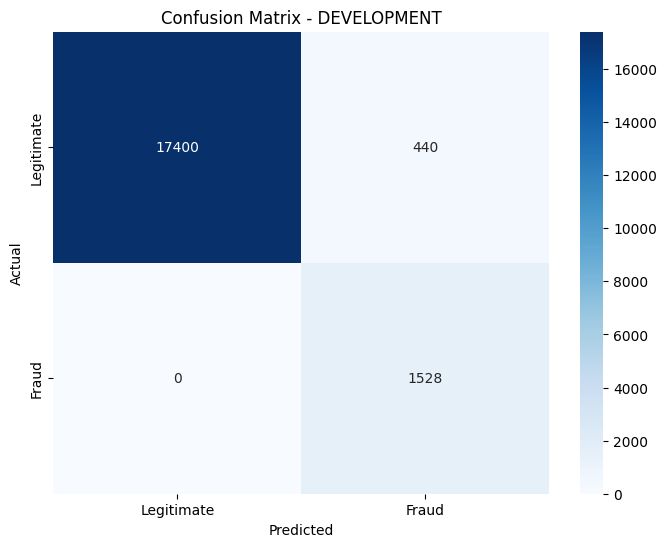


TEST Confusion Matrix Breakdown:
True Negatives (Correctly identified legitimate): 5,588
False Positives (Legitimate flagged as fraud): 71
False Negatives (Fraud missed): 429
True Positives (Correctly identified fraud): 42


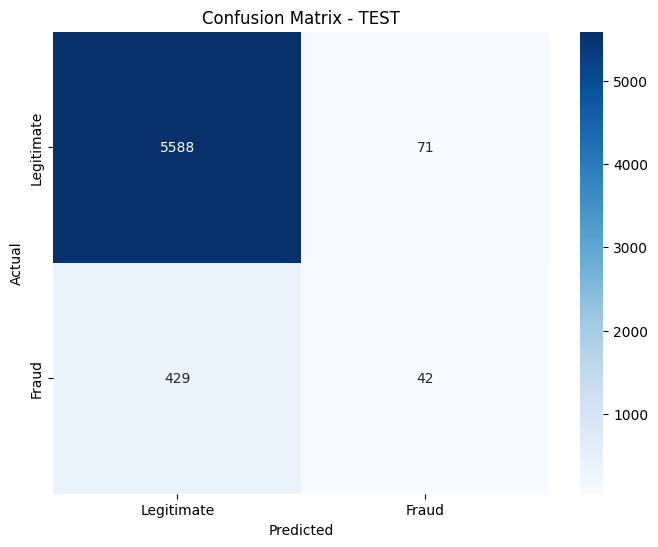


VALIDATION Confusion Matrix Breakdown:
True Negatives (Correctly identified legitimate): 5,238
False Positives (Legitimate flagged as fraud): 261
False Negatives (Fraud missed): 399
True Positives (Correctly identified fraud): 102


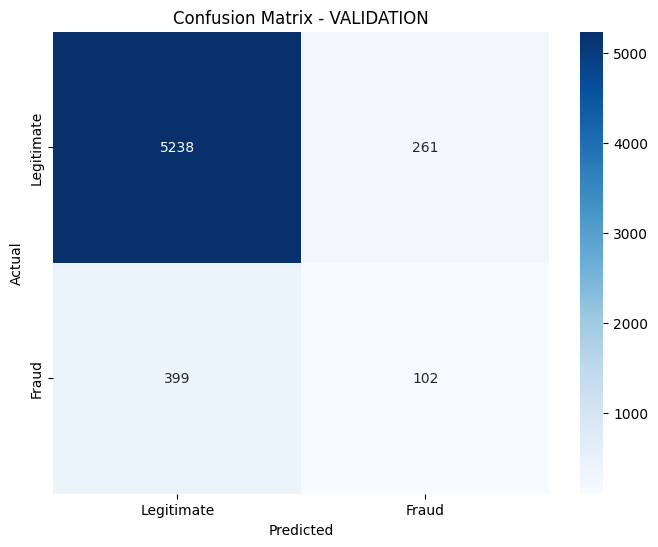

In [396]:
def plot_confusion_matrix(y_true, y_pred, dataset_name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Legitimate", "Fraud"],
        yticklabels=["Legitimate", "Fraud"],
    )
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Add interpretations
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{dataset_name} Confusion Matrix Breakdown:")
    print(f"True Negatives (Correctly identified legitimate): {tn:,}")
    print(f"False Positives (Legitimate flagged as fraud): {fp:,}")
    print(f"False Negatives (Fraud missed): {fn:,}")
    print(f"True Positives (Correctly identified fraud): {tp:,}")

    plt.show()


plot_confusion_matrix(y_dev, y_pred_dev, "DEVELOPMENT")
plot_confusion_matrix(y_test, y_pred_test, "TEST")
plot_confusion_matrix(y_valid, y_pred_valid, "VALIDATION")

DEVELOPMENT AUC-ROC: 0.9995
AUC Interpretation:
  Excellent model performance


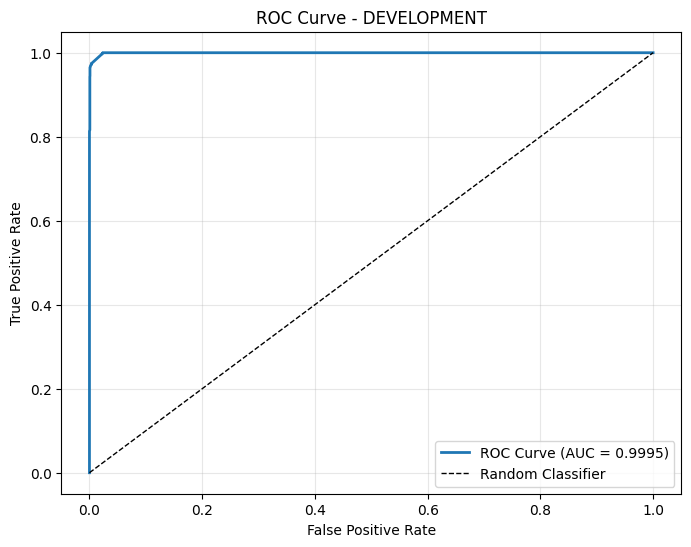

VALIDATION AUC-ROC: 0.7030
AUC Interpretation:
  Fair model performance


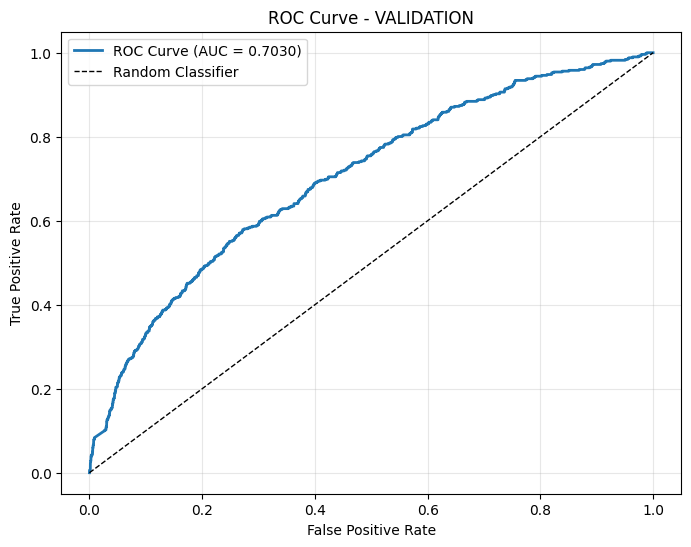

In [397]:
from sklearn.metrics import roc_curve, roc_auc_score


def plot_roc_curve(y_true, y_prob, dataset_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f"ROC Curve (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {dataset_name}")
    plt.legend()
    plt.grid(True, alpha=0.3)

    print(f"{dataset_name} AUC-ROC: {auc_score:.4f}")
    print("AUC Interpretation:")
    if auc_score >= 0.9:
        print("  Excellent model performance")
    elif auc_score >= 0.8:
        print("  Good model performance")
    elif auc_score >= 0.7:
        print("  Fair model performance")
    else:
        print("  Poor model performance")

    plt.show()


plot_roc_curve(y_dev, y_prob_dev, "DEVELOPMENT")
plot_roc_curve(y_valid, y_prob_valid, "VALIDATION")

DEVELOPMENT Average Precision: 0.9931
Baseline (random): 0.0789
Improvement over random: 12.59x


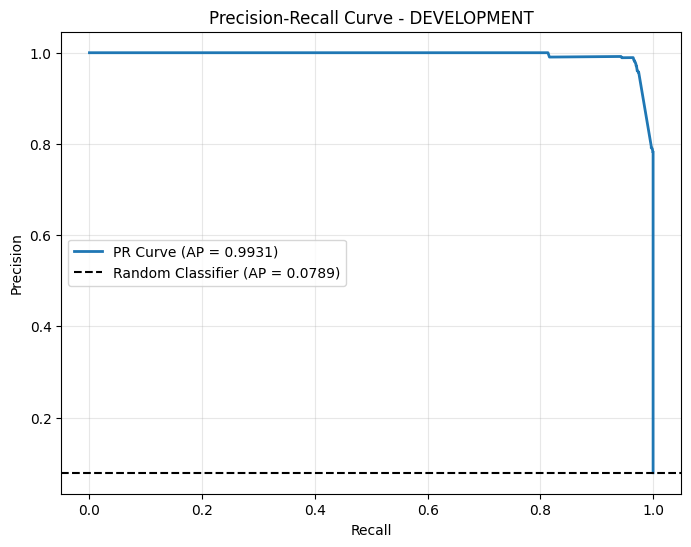

VALIDATION Average Precision: 0.2051
Baseline (random): 0.0835
Improvement over random: 2.46x


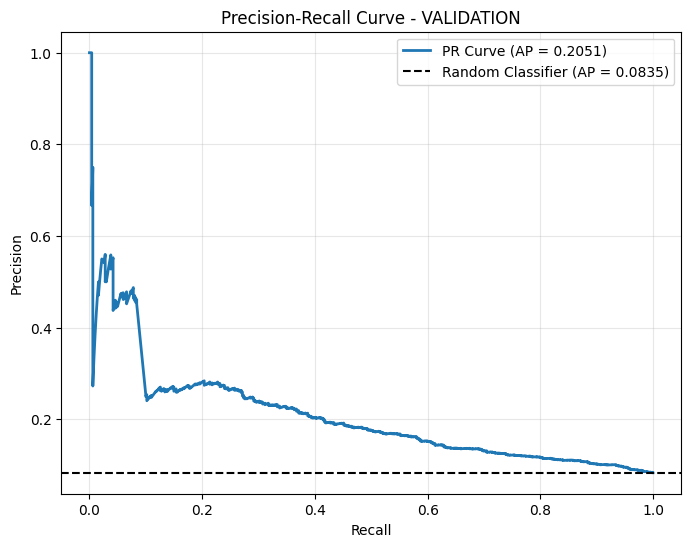

In [398]:
from sklearn.metrics import precision_recall_curve, average_precision_score


def plot_precision_recall_curve(y_true, y_prob, dataset_name):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    ap_score = average_precision_score(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, linewidth=2, label=f"PR Curve (AP = {ap_score:.4f})")

    # Add baseline (random classifier performance on imbalanced data)
    baseline = sum(y_true) / len(y_true)
    plt.axhline(
        y=baseline,
        color="k",
        linestyle="--",
        label=f"Random Classifier (AP = {baseline:.4f})",
    )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {dataset_name}")
    plt.legend()
    plt.grid(True, alpha=0.3)

    print(f"{dataset_name} Average Precision: {ap_score:.4f}")
    print(f"Baseline (random): {baseline:.4f}")
    print(f"Improvement over random: {ap_score/baseline:.2f}x")

    plt.show()


plot_precision_recall_curve(y_dev, y_prob_dev, "DEVELOPMENT")
plot_precision_recall_curve(y_valid, y_prob_valid, "VALIDATION")

=== THRESHOLD OPTIMIZATION ===


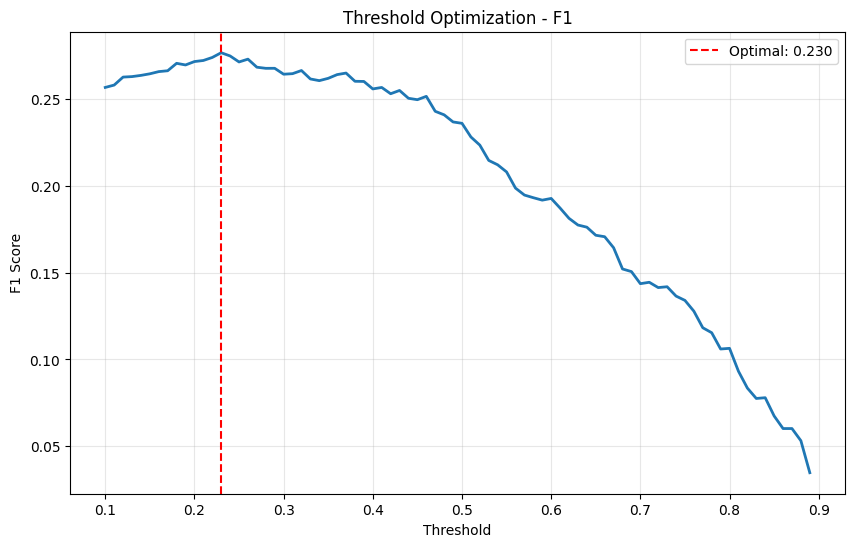

Optimal F1 threshold: 0.230 (F1: 0.2768)


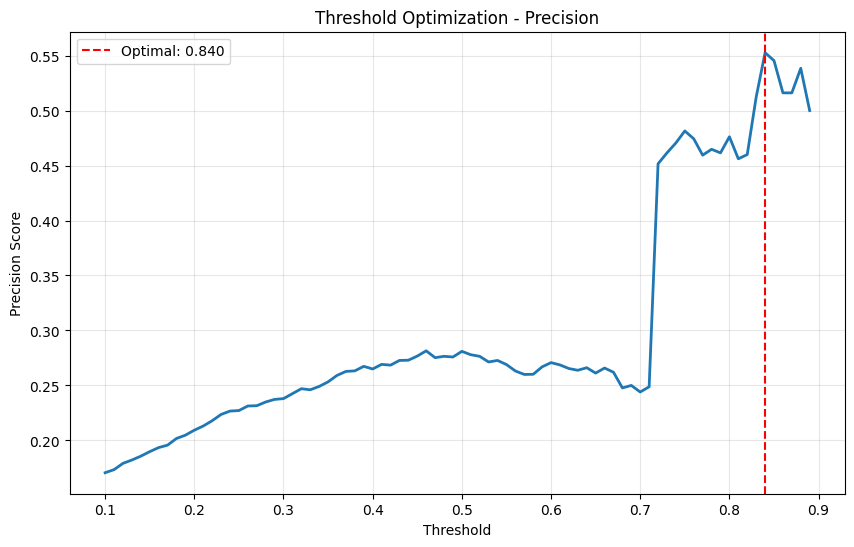

Optimal Precision threshold: 0.840 (Precision: 0.5526)


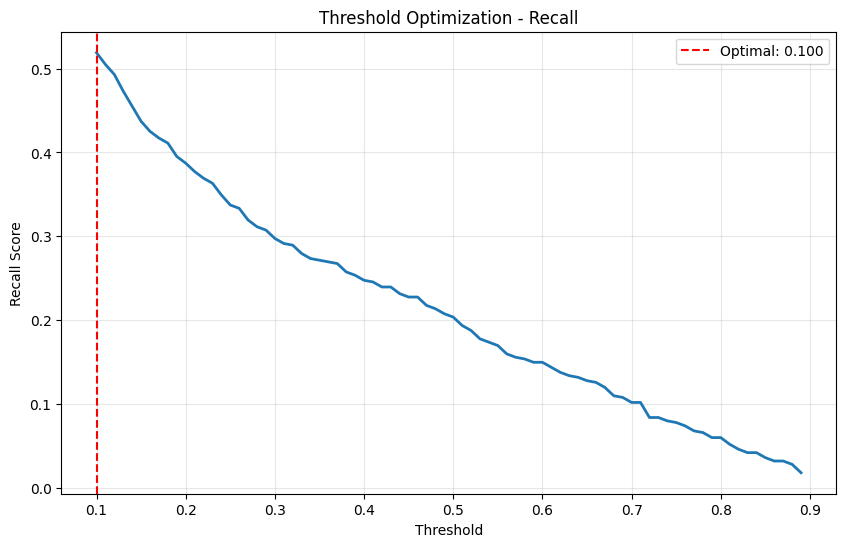

Optimal Recall threshold: 0.100 (Recall: 0.5190)


In [399]:
import numpy as np


def find_optimal_threshold(y_true, y_prob, metric="f1"):
    """Find optimal threshold based on different criteria"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []

    for threshold in thresholds:
        y_pred_thresh = (y_prob >= threshold).astype(int)

        if metric == "f1":
            score = f1_score(y_true, y_pred_thresh)
        elif metric == "precision":
            score = precision_score(y_true, y_pred_thresh)
        elif metric == "recall":
            score = recall_score(y_true, y_pred_thresh)

        scores.append(score)

    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_score = scores[optimal_idx]

    # Plot threshold vs metric
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, scores, linewidth=2)
    plt.axvline(
        x=optimal_threshold,
        color="red",
        linestyle="--",
        label=f"Optimal: {optimal_threshold:.3f}",
    )
    plt.xlabel("Threshold")
    plt.ylabel(f"{metric.capitalize()} Score")
    plt.title(f"Threshold Optimization - {metric.capitalize()}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return optimal_threshold, optimal_score


# Find optimal thresholds for different metrics
print("=== THRESHOLD OPTIMIZATION ===")
opt_thresh_f1, opt_score_f1 = find_optimal_threshold(y_valid, y_prob_valid, "f1")
print(f"Optimal F1 threshold: {opt_thresh_f1:.3f} (F1: {opt_score_f1:.4f})")

opt_thresh_precision, opt_score_precision = find_optimal_threshold(
    y_valid, y_prob_valid, "precision"
)
print(
    f"Optimal Precision threshold: {opt_thresh_precision:.3f} (Precision: {opt_score_precision:.4f})"
)

opt_thresh_recall, opt_score_recall = find_optimal_threshold(
    y_valid, y_prob_valid, "recall"
)
print(
    f"Optimal Recall threshold: {opt_thresh_recall:.3f} (Recall: {opt_score_recall:.4f})"
)